In [1]:
from typing import Annotated,TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode,tools_condition
from dotenv import load_dotenv
import requests
import gradio as gr
from langchain.agents import Tool
from langchain_openai import ChatOpenAI
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_community.utilities import GoogleSerperAPIWrapper
import os

In [2]:
#load crediential
load_dotenv(override=True)

True

In [3]:
class State(TypedDict):
    messages:Annotated[list,add_messages]
    

In [4]:
pushover_token = os.getenv("PUSHOVER_TOKEN")
pushover_user = os.getenv("PUSHOVER_USER")
pushover_url = "https://api.pushover.net/1/messages.json"

def push(text:str):
    "send the notification to the user"
    requests.post(pushover_url,data={"token":pushover_token,"user":pushover_user,"message":text})

tool_push=Tool(
    name="send_totifaction_push",
    func=push,
    description="useful when you want the send a push notification"
)

In [5]:
serper=GoogleSerperAPIWrapper()
serper.run("what is capital od india")

"New Delhi is the capital of India and a part of the National Capital Territory of Delhi (NCT). New Delhi is the seat of all three branches of the Government ... Delhi, officially the National Capital Territory (NCT) of Delhi, is a city and a union territory of India containing New Delhi, the capital of India. New Delhi, national capital of India. It is situated in the north-central part of the country on the west bank of the Yamuna River. India's capital and most populous city is Delhi, home to 31 million residents. From its origins as 'Indraprastha' in the Mahabharata to becoming the capital in 1911, Delhi blends ancient charm and modern governance. In 1911, Delhi became the centre of all activities after the capital was shifted from Kolkata. It was made a Union Territory in 1956. Lying in the northern ... Delhi is a city and national capital territory in north-central India. The city of Delhi actually consists of two components: Old Delhi, in the north, ... Yes, the capital of India

In [6]:

import nest_asyncio
nest_asyncio.apply()

In [7]:
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.utils import create_async_playwright_browser

# If you get a NotImplementedError here or later, see the Heads Up at the top of the notebook

async_browser =  create_async_playwright_browser(headless=False)  # headful mode
toolkit = PlayWrightBrowserToolkit.from_browser(async_browser=async_browser)
tools = toolkit.get_tools()

In [8]:
for tool in tools:
    print(f"{tool.name}={tool}")

click_element=async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\redhu\AppData\Local\ms-playwright\chromium-1169\chrome-win\chrome.exe> version=136.0.7103.25>
navigate_browser=async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\redhu\AppData\Local\ms-playwright\chromium-1169\chrome-win\chrome.exe> version=136.0.7103.25>
previous_webpage=async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\redhu\AppData\Local\ms-playwright\chromium-1169\chrome-win\chrome.exe> version=136.0.7103.25>
extract_text=async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\redhu\AppData\Local\ms-playwright\chromium-1169\chrome-win\chrome.exe> version=136.0.7103.25>
extract_hyperlinks=async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\redhu\AppData\Local\ms-playwright\chromium-1169\chrome-win\chrome.exe> version=136.0.7103.25>
get_elements=async_browser=<Browser type=<BrowserT

In [11]:
tool_dict = {tool.name:tool for tool in tools}

navigate_tool = tool_dict.get("navigate_browser")
extract_text_tool = tool_dict.get("extract_text")

    
await navigate_tool.arun({"url": "https://www.aajtak.in/"})
text = await extract_text_tool.arun({})

In [12]:
import textwrap
print(textwrap.fill(text))

Hindi news, हिंदी न्यूज़ , Hindi Samachar, हिंदी समाचार, Latest News in
Hindi, Breaking News in Hindi, ताजा ख़बरें, Aaj Tak News Aaj Tak বাংলা
GNTTV India Today Malayalam Business Today Lallantop इंडिया टुडे हिंदी
NewsTak UPTak Sports Tak KisanTak MumbaiTak BT Bazaar Cosmopolitan
Harper's Bazaar Northeast Brides Today Reader’s Digest Astro Tak
Gaming Sign In Hindi News Sign In Edition IN US होम भारत दिल्ली उत्तर
प्रदेश मध्य प्रदेश राजस्थान बिहार पंजाब हरियाणा पश्चिम बंगाल ओडिशा
हिमाचल प्रदेश महाराष्ट्र झारखंड उत्तराखंड छत्तीसगढ़ गुजरात जम्मू
कश्मीर तेलंगाना चुनाव उपराष्ट्रपति चुनाव बिहार चुनाव मनोरंजन बिग बॉस
बॉलीवुड साउथ सिनेमा वीडियो टीवी वेब स्टोरी फिल्म रिव्यू धर्म राशिफल
टैरो राशिफल लव राशिफल आर्थिक राशिफल करियर राशिफल मूलांक राशिफल विजुअल
स्टोरी वीडियो पर्व-त्यौहार आरती संग्रह पूजा-पाठ लाइफस्टाइल वेब स्टोरी
खेल एशिया कप महिला वर्ल्ड कप क्रिकेट न्यूज विजुअल स्टोरी वीडियो आगामी
मैच वीडियो बिजनेस बजट 2025 रियल एस्टेट वेब स्टोरी स्टॉक अपडेट्स हॉट
स्टॉक क्रिप्टो गोल्ड-सिल्वर रेट पेट्रो

In [13]:
tool_search=Tool(
    name='search',
    func=serper.run,
    description="usefum when you need information form web search"
)

In [14]:
all_tools=[tool_search,tool_push]+tools

In [15]:
model=ChatOpenAI(model='gpt-4o-mini')
model_with_tools=model.bind_tools(all_tools)

In [16]:
#define chatbot node
def chatbot(State):
    return {"messages":model_with_tools.invoke(State['messages'])}

In [17]:
#define memory
db_path="memory.db" 
conn=sqlite3.connect(db_path,check_same_thread=False)
sql_memory=SqliteSaver(conn)

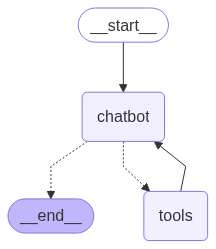

In [18]:
from IPython.display import display,Image
#buid graph
graph=StateGraph(State)

#add node
graph.add_node('chatbot',chatbot)
graph.add_node('tools',ToolNode(tools=tools))

#create edges
graph.add_edge(START,'chatbot')
graph.add_edge('tools','chatbot')
graph.add_conditional_edges( "chatbot", tools_condition, "tools")

#compile_graph
workflow=graph.compile(checkpointer=sql_memory)

#display the graph
display(Image(workflow.get_graph().draw_mermaid_png()))




In [19]:
config = {"configurable": {"thread_id": "1"}}

In [20]:
def chat(user_input: str, history):
    result = workflow.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content
    
gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
